<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%9D%D0%A1_%D1%81_%D0%BF%D0%BE%D0%B4%D0%BA%D1%80%D0%B5%D0%BF%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание и загрузка библиотек

1. Запустите нейросеть на разном количестве тренировок, сравните результаты:

10 тренировок - количество выигранных очков?

20 тренировок - количество выигранных очков?

30 тренировок - количество выигранных очков?

2. Проведите небольшую тренировочную сессию, изменив архитектуру нейросети:

изменив количество связей в Dense слое,

добавив Dense слой,

добавив Conv слой.

Результаты сравните.

In [ ]:
!pip install gym==0.18.3
!pip install atari-py==0.2.5

     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657532 sha256=62057265f06b1b2985680954fac53ec449d179ae4a7ebd107721aeda1365dd4e
  Stored in directory: /root/.cache/pip/wheels/1a/ec/6d/705d53925f481ab70fd48ec7728558745eeae14dfda3b49c99
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 2.8 MB 5.3 MB/s 
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [ ]:
import gym # тренажёр
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, load_model #  и абстрактный класс базовой модели
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
%matplotlib inline

tf.compat.v1.disable_eager_execution()

**Задание выполнял сразу на добавленных слоях Dense и одного слоя Conv2D с 30 тренировками. Поясню. Базовую сеть делал в Ультра Лайт и разобрал по косточкам, а 30 тренировок. Нет смысла повторять сначала 10, потом 20 и наконец 30, результат тот же. Но если буду заново запускать функции, т.е. сначала, то поменяются вероятности.. соответсвенно результат будет безсмыленен, вернее вывод.**

# Игра

In [ ]:
env = gym.make('Pong-v0') # среда игры Понг
observation = env.reset() #  Начальное состояние
observation.shape

(210, 160, 3)

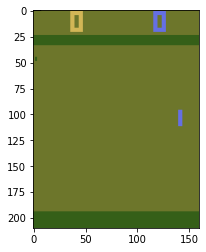

In [ ]:
plt.imshow(observation)
plt.show()

вводим обозначения:

0 - цифровое обозначение, если ракетка "стоит на месте"

2 - сдвинуться вверх

3 - сдвинуться вниз

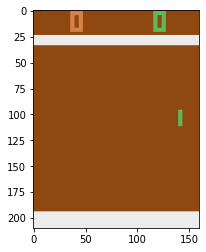

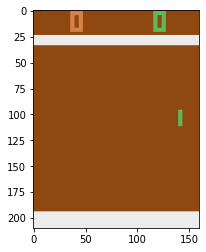

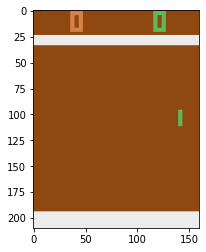

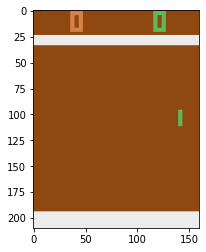

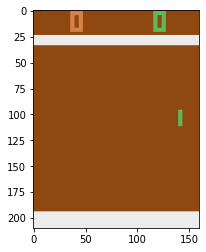

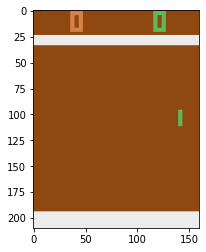

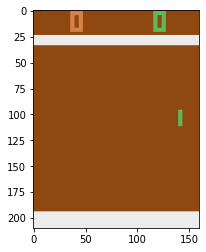

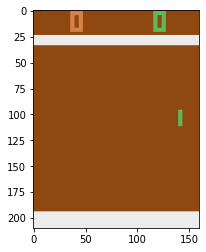

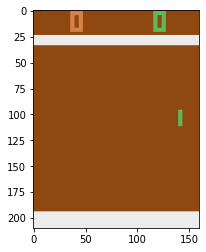

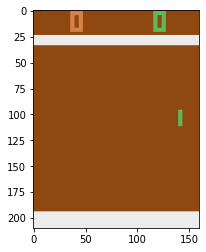

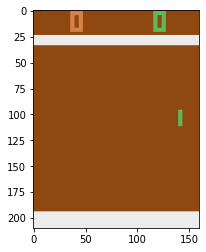

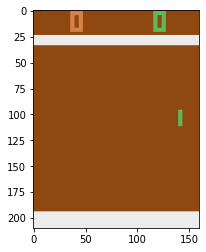

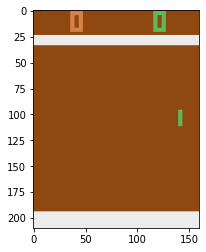

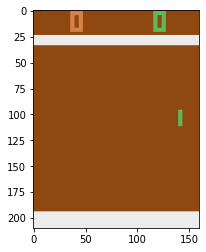

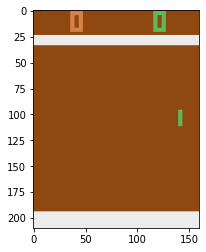

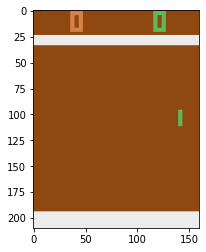

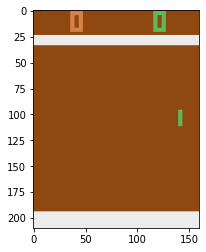

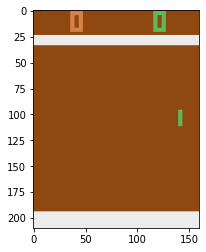

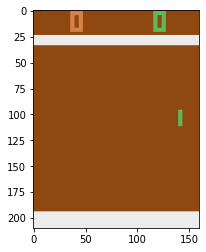

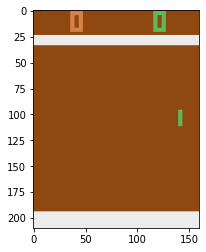

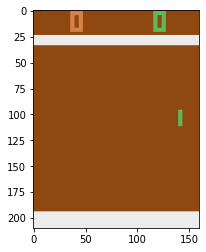

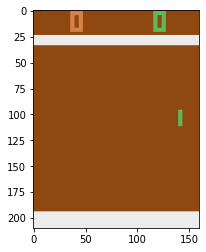

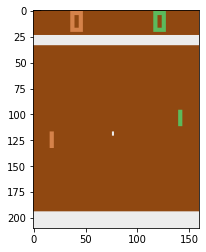

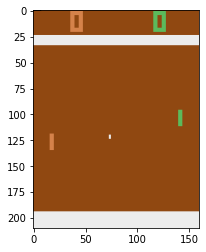

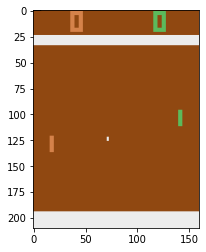

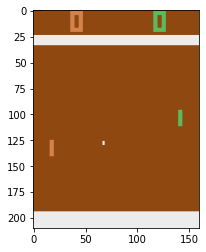

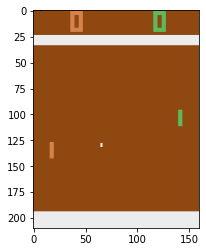

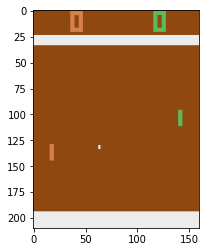

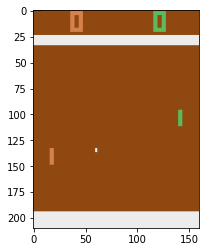

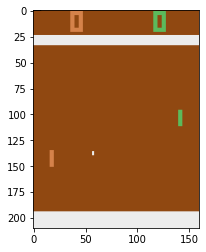

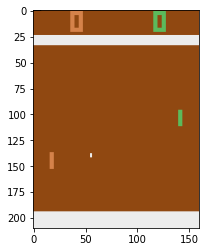

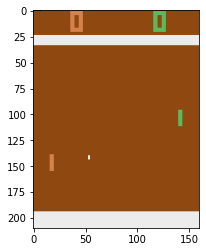

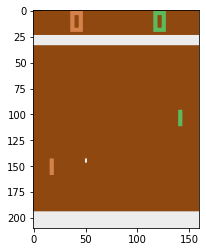

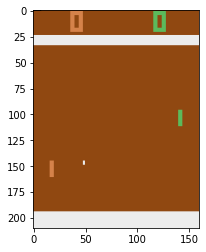

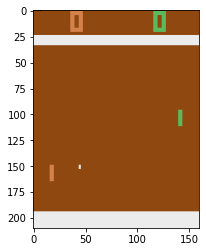

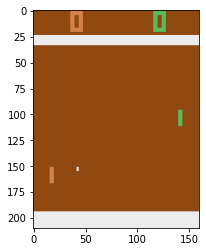

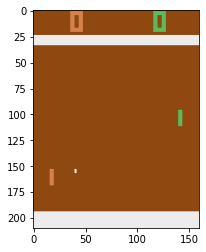

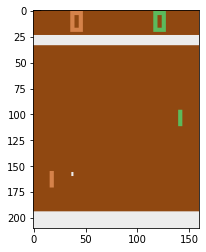

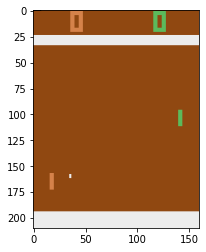

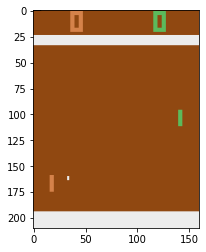

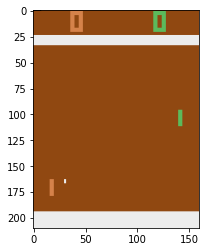

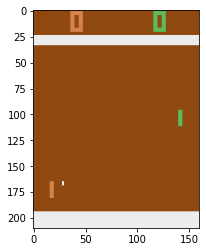

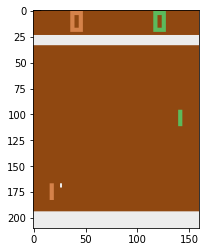

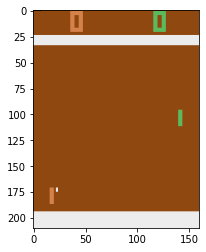

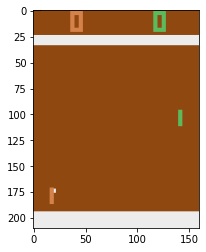

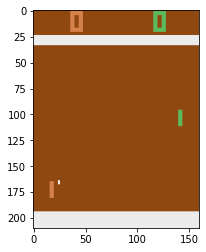

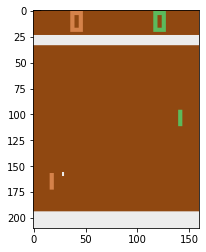

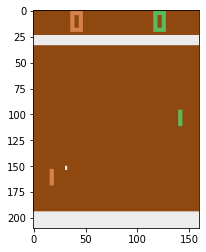

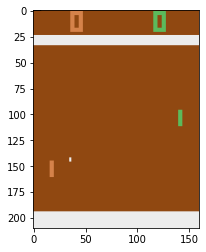

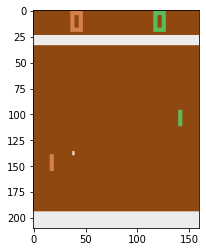

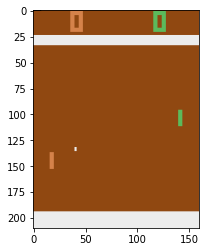

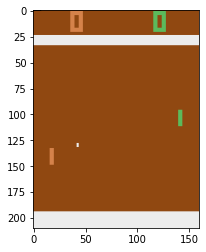

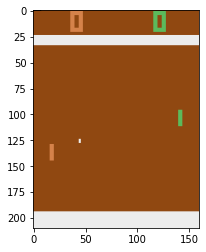

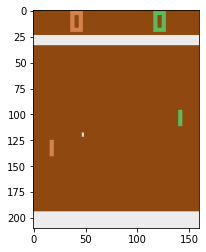

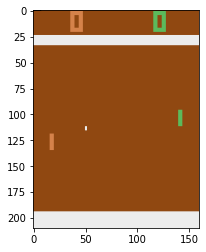

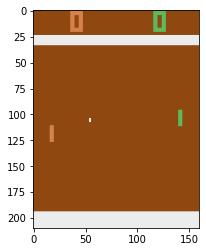

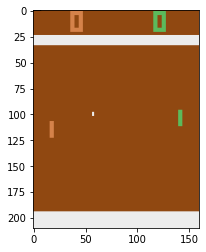

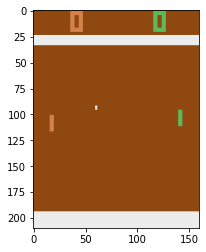

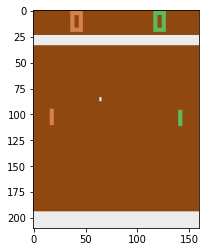

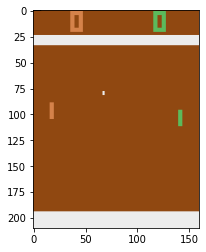

In [ ]:
for i in range(60): # поиграем на 60 кадров вперёд
  observation, reward, done, info = env.step(0) # 0 - На месте
# step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)
# observation (object) - текущее состояние среды, которое наблюдает агент(пиксели)
# reward (float) - награда за совершённое действие
# done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)
# info (dict) - вспомогательная диагностическая информация, типа кол-во оставшихся жизней(неактуально для понга)
  plt.imshow(observation)
  plt.show()

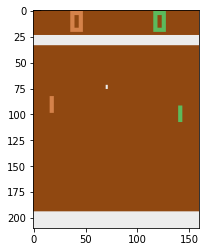

In [ ]:
newObservation, reward, done, info = env.step(2) # движение вверх
plt.imshow(newObservation)
plt.show()

# Предобработка данных

оставить на экране только мяч и ракетки. Остальное убираем

In [ ]:
def preprocessFrames(newFrame, lastFrame):
  nFrame = newFrame.astype(np.int32) #  в целые числа
  nFrame[nFrame == 144] = 0 # обнуляем ораженвый фон
  nFrame[nFrame == 72] = 0 
  lFrame = lastFrame.astype(np.int32) # предыдущий кадр
  lFrame[lFrame == 144] = 0 #  также обнуляем оранжевый фон
  lFrame[lFrame == 72] = 0
  deltaFrame = nFrame - lFrame #  разница между новым и предыдущим кадром
  deltaFrame = deltaFrame[35:195] #  остаётся картинка 160*160
  deltaFrame = deltaFrame[::2, ::2, 0] # сжимаем в два раза. Будет 80*80
  maxValue = deltaFrame.max() if deltaFrame.max() > abs(deltaFrame.min()) else abs(deltaFrame.min()) #  ни фига не понял
  if maxValue != 0:
    deltaFrame = deltaFrame / maxValue
  return deltaFrame

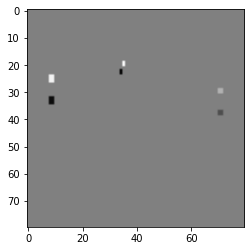

In [ ]:
plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray)

In [ ]:
preprocessFrames(newObservation, observation).shape # проверяем размер

(80, 80)

# Нейронка

In [ ]:
preprocessFrames(newObservation, observation)
inputs = Input(shape=(80,80))
x = Dense(128)(inputs)
x = Dense(80, activation='relu', use_bias=False)(x)
x = BatchNormalization()(x)
x = Reshape((80,80,1))(x)
#x = Flatten()(inputs)

x = Conv2D(16, 2, padding='same')(x)
x = Flatten()(x)
x = Dense(32, activation='relu', use_bias=False)(x)
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(x)

policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)
policyNetworkModel.summary()


Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80)]          0         
                                                                 
 dense (Dense)               (None, 80, 128)           10368     
                                                                 
 dense_1 (Dense)             (None, 80, 80)            10240     
                                                                 
 batch_normalization (BatchN  (None, 80, 80)           320       
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 80, 80, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 16)        

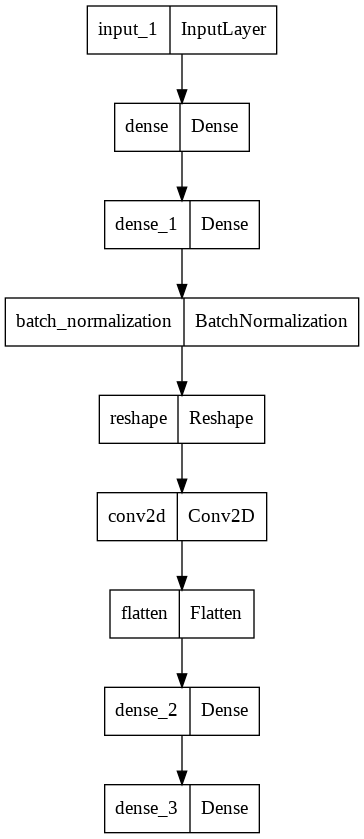

In [ ]:
plot_model(policyNetworkModel)

## функция потерь в соотвествии с вознаграждением

In [ ]:
episodeReward = Input(shape=(1, ), name='episodeReward') #награда

In [ ]:
def rewardedLoss(episodeReward): # вознаграждение за потерю
  def loss(yTrue, yPred): # yTrue-сделанное движение: вверх-1, вниз-0
    # подаём в кач-ве yTrue фактически сделанное действие(action) 
    # если фактически сделанное действие было движением вверх - подаем 1 на yTrue, если нет то подаем 0
    # yPred - выход сетки(вероятность выбора движения вверх)
    # мы не подаём yPred в нейронку, его вычисляет керас
    
    # сначала log(0) and log(1) неопределены - загоняем yPred между значениями: 0.05 и 0.95
    tmpPred = Lambda(lambda x: keras.backend.clip(x, 0.05, 0.95))(yPred)
# формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды 
    tmpLoss = Lambda(lambda x: -yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
# обновлённая функция потерь - "функция политики"
    policyLoss = Multiply()([tmpLoss, episodeReward])
    return policyLoss
  return loss

In [ ]:
policyNetworkTrain = Model(inputs=[inputs, episodeReward], outputs=sigmoidOutput)
myOptimizer = RMSprop(lr=0.0001)
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


# Генерация игрового эпизода с участием НС

игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша.

Сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой.

reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим кадром, полученную функцией preprocessFrames.

In [ ]:
def generateEpisode(policyNetwork):
  stateList = [] # список состояний в течении эпизода (х, 80, 80)
  upDownActionList = [] # список.. вверх-1, вниз-0
  rewardsList = []# список наград за каждое действие
  networkOutputList = [] # вероятности на выходе на каждом шаге
  env = gym.make('Pong-v0') # создаём среду
  observation = env.reset() # перезагрузка среды
  newObservation = observation # новое состояние
  done = False # игровой эризод не завершён

  while done==False:
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation)# состояние между кадрами
    stateList.append(processedNetworkInput) # чёрно-белые кадры, потом будет "х". Список состояний
    reshapeInput = np.expand_dims(processedNetworkInput, axis=0) # размер "х"-(80, 80) в (х, (1, 80, 80))

    upProbability = policyNetwork.predict(reshapeInput, batch_size=1)[0][0] #вероятность шага вверх. входное значение ф-ции
    networkOutputList.append(upProbability) # добавляем вероятность шага вверх
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
# сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
    if actualAction==2: # если рандомно пошли вверх
      upDownActionList.append(1.0)# добавляем в список 
    else:
      upDownActionList.append(0.0)#  иначе 3, вниз. добавляем в список.
    
    observation = newObservation # текущий newObservation,  записываем как старый
    newObservation, reward, done, info = env.step(actualAction) #  новый шаг
    rewardsList.append(reward) #  награды в список
    if done: #  если игровой цикл закончится True
      break
  env.close() # закрытие текущей среды
  return stateList, upDownActionList, rewardsList, networkOutputList# состояние,  движение, награда, вероятность движения 

## генерация эпизода игры с необученной сетью policyNetworkModel

In [ ]:
# что вернулось, запускаем в этой же функции
stateList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print()
print('****'*5)
print('Количество состояний в эпизоде=' + str(len(stateList)))
print('Форма состояния: ' + str(stateList[0].shape))
print(str(len(upDownActionList)))
print('Количество наград за эпизод: ' + str(len(rewardsList)))
print('****'*5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



********************
Количество состояний в эпизоде=1427
Форма состояния: (80, 80)
1427
Количество наград за эпизод: 1427
********************


In [ ]:
#  фрагмент
print(networkOutputList[10:25])

[0.5020289, 0.50222313, 0.49856764, 0.5046773, 0.4975733, 0.4967032, 0.5021461, 0.49749285, 0.5008519, 0.501295, 0.4995921, 0.50643235, 0.4966364, 0.50080174, 0.50372976]


In [ ]:
upDownActionList[10:25]

[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]

In [ ]:
print(rewardsList[10:25])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList))))) #с фильтром по 0

Количество выигранных очков = 0
Количество проигранных очков = 21
Количество нулевых наград = 1406


# Вознаграждение

In [ ]:
def processRewards(rewardsList):
  rewardDecay = 0.99
  tmpReward = 0 # временная переменная для награды
  rewardDecayed = np.zeros_like(rewardsList, dtype=np.float32) #  массив из нулей
  for i in range(len(rewardsList)-1, -1, -1):
    if rewardsList[i]==0:
      tmpReward = tmpReward*rewardDecay #зададим коэффициент
      rewardDecayed[i] = tmpReward #  добавляем в массив
    else:
      tmpReward = rewardsList[i] #  оставляем награду как есть
      rewardDecayed[i] = tmpReward #  также в массив
  rewardDecayed -= np.mean(rewardDecayed) #  нормализация наград и вычитаем среднее
  rewardDecayed /= np.std(rewardDecayed) #  делим на стандартное отклонение
  return rewardDecayed

отрисуем список наград

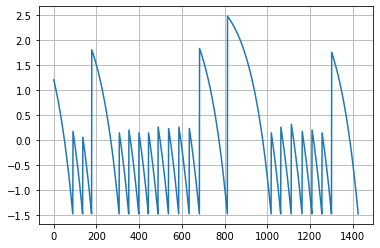

In [ ]:
plt.plot(processRewards(rewardsList), '-')
ax = plt.gca()
ax.grid(True)
plt.show()

#Игровой эпизод с последующей тренировкой

In [ ]:
stateList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel) # по новому
print()
print('****'*5)
print('Количество состояний в эпизоде=' + str(len(stateList)))
print('Форма состояния: ' + str(stateList[0].shape))
print('Количество наград за эпизод: ' + str(len(rewardsList)))
print('****'*5)


********************
Количество состояний в эпизоде=1472
Форма состояния: (80, 80)
Количество наград за эпизод: 1472
********************


In [ ]:
x = np.array(stateList) # как массив
episodeReward = np.expand_dims(processRewards(rewardsList), 1) # метод добавляет размерность. подбиваем массив 
yTmp = np.array(upDownActionList) # движение вверх вниз массив, пока одномерный
yTrue = np.expand_dims(yTmp, 1) #  также подбиваем массив
print('****'*5)
print("Форма наград за эпизод =", episodeReward.shape) # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)              # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)     # выведем форму фактических движений ('y' для нейросети)

********************
Форма наград за эпизод = (1472, 1)
Форма состояний среды = (1472, 80, 80)
Форма фактических движений = (1472, 1)


In [ ]:
episodeReward[:10]

array([[1.0865272],
       [1.0813906],
       [1.0762022],
       [1.0709612],
       [1.0656675],
       [1.0603201],
       [1.0549188],
       [1.0494629],
       [1.043952 ],
       [1.0383854]], dtype=float32)

In [ ]:
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Train on 1472 samples
1472/1472 [==============================] - 2s 2ms/sample - loss: -0.0139


## серия игровых эпизодов

In [ ]:
# на фига такие длинные названия функции
def generateEpisodeBatchesTraining(model, nBatches=10): # количество игровых серий
  env = gym.make('Pong-v0')
  batchStateList = [] # список состояний
  batchUpDownActionList = [] # список движений
  batchRewardsList = [] # список наград
  batchNetworkOutputList = [] # список из вероятностей идти вверх
  for i in range(nBatches):
    stateList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model)
    batchStateList.extend(stateList) # extend добавляем к спискам другой список
    batchNetworkOutputList.extend(networkOutputList) #  В список состояний
    batchUpDownActionList.extend(upDownActionList) # в список движений
    batchRewardsList.extend(rewardsList) # в серию списков наград

  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # провторяем процедуру
  x = np.array(batchStateList)
  yTmp = np.array(batchUpDownActionList)
  yTrue = np.expand_dims(yTmp,1)

  history = policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue, epochs=5, verbose=0)

  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss

## обучение серии эпизодов

**30 тренировок**

In [ ]:
trainTimes = 30 # количестов тренировок
for training in range(trainTimes):
  startTime = time.time()
  stateList, upDownActionList, rewardsList, networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, nBatches=10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1)) # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 3)))# выведем на экран ошибку на тренировке
  rr=np.array(rewardsList) # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 5 == 0:  # через каждые 5 эпизодов
    policyNetworkModel.save("policyNetworkModel.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5") # сохраняем модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple.txt','a') as recordingRewards: #  в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 106сек
Ошибка на тренировке = -0.335
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 2
Время тренировки = 75сек
Ошибка на тренировке = -0.387
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 3
Время тренировки = 93сек
Ошибка на тренировке = -0.305
Выиграли очков = 10 Проиграли очков = 210

Тренировка = 4
Время тренировки = 76сек
Ошибка на тренировке = -0.653
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 5
Время тренировки = 91сек
Ошибка на тренировке = -0.458
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 6
Время тренировки = 78сек
Ошибка на тренировке = -0.693
Выиграли очков = 1 Проиграли очков = 210

Тренировка = 7
Время тренировки = 78сек
Ошибка на тренировке = -0.674
Выиграли очков = 1 Проиграли очков = 210

Тренировка = 8
Время тренировки = 73сек
Ошибка на тренировке = -0.835
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 9
Время тренировки = 75сек
Ошибка на тренировке = -0.734
Выиграли очков = 1 Проиграли оч

In [ ]:
# Импорт библиотек для записи и воспроизведения видео
###########################
from IPython.display import clear_output
!apt update && apt install xvfb && pip install pyvirtualdisplay 
# # "apt-get..." - установка пакета программного обеспечения
# # "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран

from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
clear_output()
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
# Задаем функцию сыграть и показать игру
###########################
def playAndShowEpisode(policyNetwork): # подаем на вход функции модель нейросети
    env = wrapEnv(gym.make('Pong-v0')) # создаем среду в режиме записи
    done = False                       # игровой эпизод не завершён
    observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    newObservation = observation       # задали новое состояние которое наблюдает агент
    while done == False:               # пока игровой эпизод не завершён
        # На вход сети будет подаваться очередное состояние - разница между кадрами. 
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation) # зададим это состояние
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0] # задаем вероятность шага вверх
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
        
        env.render()                   # запускаем воспроизведение среды
        
        observation = newObservation   # текущий newObservation записываем как старый, перед тем как сделать следующий шаг
        newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    env.close() # закрываем игровую среду после окончания игры
    showVideo() # показать видео игры

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
policyNetworkModel = load_model("/content/policyNetworkModel.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel) 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


**Вывод:** В прошлый раз запускал, но рандомно результат был получше. На данный момент, результат оставляет желать лучшего, тут невозможно сказать об эффективности данной архитектуры. хотя делая задание на ультра лайте с одним полносвязным слоем, на протяжении 30 тренировок ( а их было 121), было подмечено, что количество выигрышей было в разы больше, и доходило до 53. Но, опять же это не показатель, т.к. вороятности идут рандомно и чётко не заданы. Задание собственно лишь на понимание процесса. Много доставило времени на поиск синтаксических ошибок 80% затраченного времени. 